In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        
def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: a matrix.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.empty((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x

def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)
    return inputs, labels

## Boilerplate Code Above
### Importing the Data and checking how it is looking

In [3]:
ds_train_set_path = "C:/Users/acer/Desktop/Data_Structures_And_Algorithms/Crescer_AI/scr-dataset.csv"

In [4]:
x_train, y_train = load_dataset(ds_train_set_path, add_intercept=True)

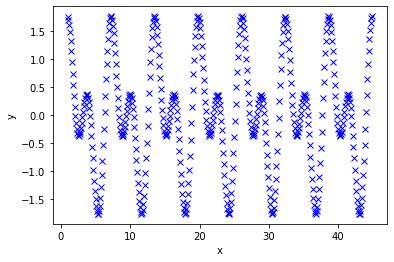

In [5]:
def plot(x, y_label, y_pred, title):
    plt.figure()
    plt.plot(x[:,-1], y_label, 'bx', label='label')
    plt.plot(x[:,-1], y_pred, 'ro', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')

plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_train[:, -1], y_train, 'bx', linewidth=2)

## Basic Functions cannot fit in the above figure,  a pattern can be seen but exactly what function it is, hard to see therefore using one the models which is very good at shifting itself according to the value inputted
## Using Locally Weighted Linear Regression

In [6]:
class LocallyWeightedLinearRegression(LinearModel):
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.

        :param x: Training example inputs. Shape (m, n).
        :param y: Training example labels. Shape (m,).
        """

        self.x = x
        self.y = y

    def predict(self, x):
        """Make predictions given inputs x.

        :param x: Inputs of shape (l, n).
        :return:  Outputs of shape (l,).
        """
        l, n = x.shape

        # Reshape the input x by adding an additional dimension so that it can broadcast
        w_vector = np.exp(- np.linalg.norm(self.x - np.reshape(x, (l, -1, n)), ord=2, axis=2)**2 / (2 * self.tau**2))

        # Turn the weights into diagonal matrices, each corresponds to a single input. Shape (l, m, m)
        w = np.apply_along_axis(np.diag, axis=1, arr=w_vector)

        # Compute theta for each input x^(i). Shape (l, n)
        theta = np.linalg.inv(self.x.T @ w @ self.x) @ self.x.T @ w @ self.y

        return np.einsum('ij,ij->i', x, theta)

## Fitting the model and checking with a default value of tau what predictions we are getting

In [7]:
model = LocallyWeightedLinearRegression(tau=0.5)
model.fit(x_train, y_train)

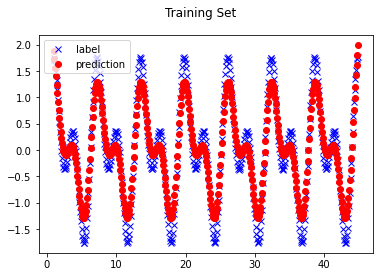

In [8]:
y_train_pred = model.predict(x_train)
plot(x_train, y_train, y_train_pred, 'Training Set')

## Checking for few of the famous random tau initiations
## As in our above figure we observe underfitting, we want more clean fit, therefore by intuition our tau should decrease...

Tau = 0.03 achieves the lowest MSE on the validation set.


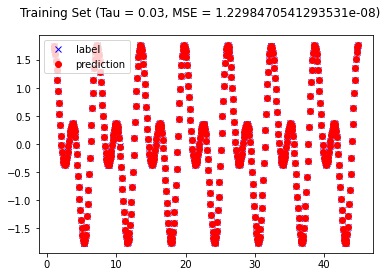

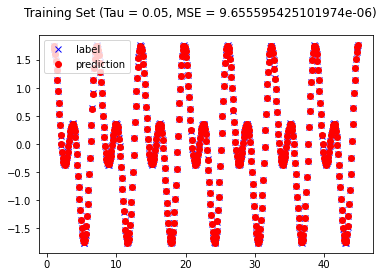

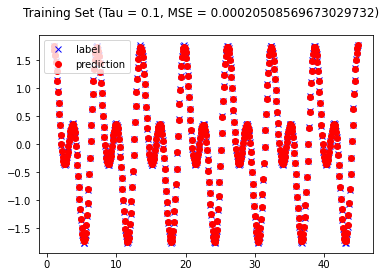

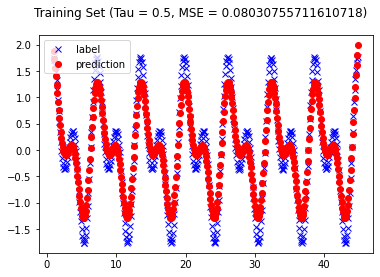

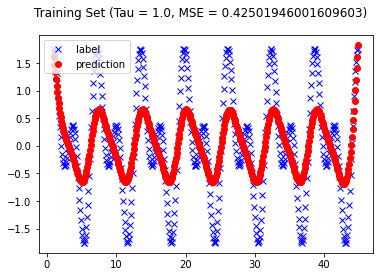

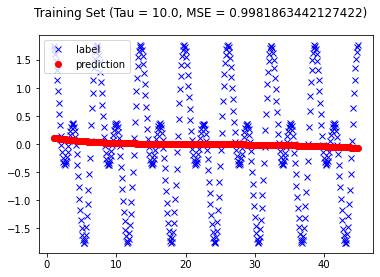

In [9]:
taus = [3e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]

lowest_mse = math.inf
best_tau = taus[0]

for tau in taus:
    model = LocallyWeightedLinearRegression(tau)
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    
    mse = np.mean((y_train_pred - y_train)**2)
    if mse < lowest_mse:
        lowest_mse = mse
        best_tau = tau

    plot(x_train, y_train, y_train_pred, f'Training Set (Tau = {tau}, MSE = {mse})')
    
print(f'Tau = {best_tau} achieves the lowest MSE on the validation set.')

## Finally training our model again using tau = 0.03
## And making our prediction below

In [10]:
# Therefore we'll choose tau = 0.03
tau = 0.03

In [11]:
x_pred = np.ones((1, 2))
x_pred[0:0] = 50

In [12]:
model = LocallyWeightedLinearRegression(tau)
model.fit(x_train, y_train)

In [13]:
y_pred = model.predict(x_pred)
print(y_pred)

[1.75076841]
